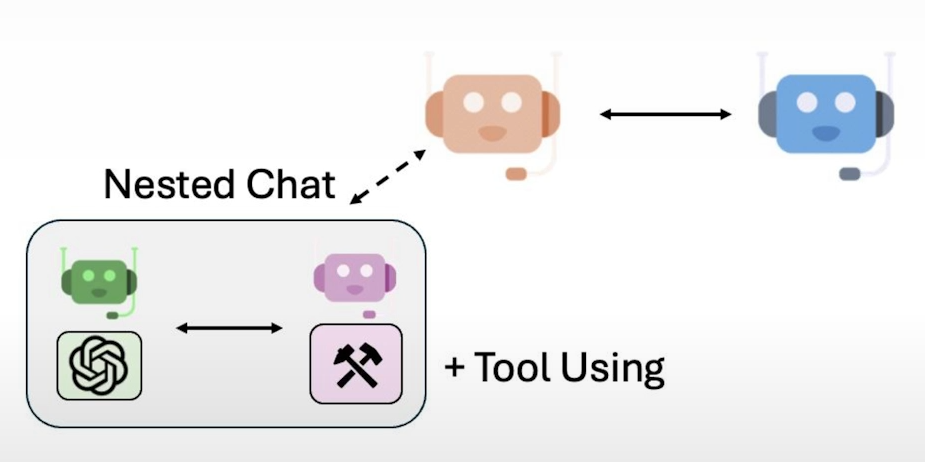

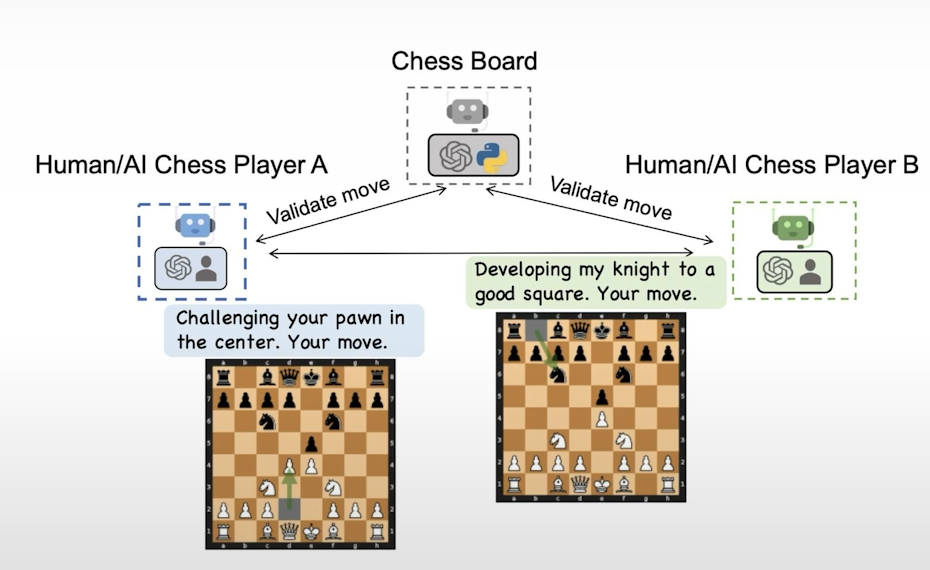

In this lesson, we're going to learn a new capability for tool using.
And we will still use a nested chat as one conversation pattern to make agents
use the tools, finish tasks, and we will build
a conversational chess game to showcase this example.
So, we will build a conversational chess game between two agent players
who both can call a tool and make legal moves on the chessboard.

# Lesson 4: Tool Use and Conversational Chess

## Setup

In [1]:
llm_config = {"model": "gpt-4-turbo"}

In [2]:
import chess
import chess.svg
from typing_extensions import Annotated

## Initialize the chess board

In [3]:
board = chess.Board()

In [4]:
made_move = False

## Define the needed tools

### 1. Tool for getting legal moves

In [5]:
def get_legal_moves(
    
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

### 2. Tool for making a move on the board

In [6]:
def make_move(
    move: Annotated[str, "A move in UCI format."]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

## Create agents

You will create the player agents and a board proxy agents for the chess board.

In [7]:
from autogen import ConversableAgent

In [8]:
# Player white agent
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [9]:
# Player black agent
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [10]:
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


In [11]:
board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

## Register the tools

A tool must be registered for the agent that calls the tool and the agent that executes the tool.

In [12]:
from autogen import register_function

In [13]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

In [14]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

## Register the nested chats

Each player agent will have a nested chat with the board proxy agent to
make moves on the chess board.

In [15]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

## Start the Game

The game will start with the first message.

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might get a slightly different moves than what's shown in the video.

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_RUbC88IjFm0BQT8skCE9DOz0): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_RUbC88IjFm0BQT8skCE9DOz

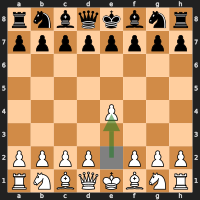

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_9iuvYqJ62CTQ94ECBB6805w9) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my pawn from e2 to e4. Your move!

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my pawn from e2 to e4. Your move!

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my pawn from e2 to e4. Your move!

-------------------------------------

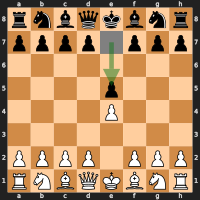

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_XMC7Hs9BZrblNsUqO47AwBQv) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my pawn from e7 to e5. Your turn! Let me know your move.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my pawn from e7 to e5. Your turn! Let me know your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my pawn from e7 to e5. You

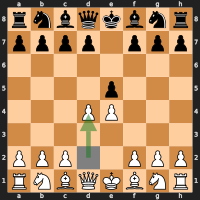

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_2zeZSYeUi4UY9UDZ4pzC4mUk) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my pawn from d2 to d4. It's your turn!

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my pawn from d2 to d4. It's your turn!

--------------------------------------------------------------------------------


In [16]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

## Adding a fun chitchat to the game!

In [17]:
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [18]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [19]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


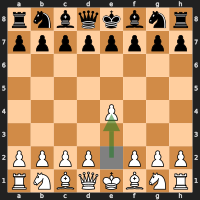


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I moved my pawn from e2 to e4, a classic opening move that controls the center and opens lines for my queen and bishop. What's your strategy going to be to contend with this move?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


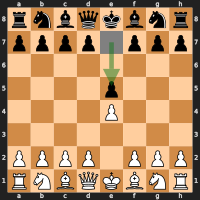


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

The pawn move e5 has been made, directly challenging your central control. This sets up a classic pawn structure that leads to lots of interesting strategic battles. Ready for your next move? What do you plan to do in response?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


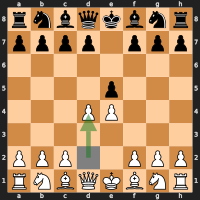


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I've advanced the pawn from d2 to d4, challenging the central control directly. This should put some tension on the board and lead to some interesting exchanges. How do you plan to respond to this classic development move? Let's see how the game unfolds from here!

--------------------------------------------------------------------------------


In [20]:
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=2,
)

**Note:** 
To add human input to this game, add **human_input_mode="ALWAYS"** for both player agents.